# Reduction Example
### Images of NGC1341 from TOROS GW170104 response
This notebook provides an exmaple of the process of image reduction using images taken of the galaxy NGC1341 by the EABA 1.54-m telescope on 19 November 2017.

The Transient Robotic Observatory of the South (TOROS) Collaboration is a network of optical telescopes designed to respond to gravitational wave alerts triggered by the LIGO and Virgo observatories. Images are taken of galaxies within the region of highest probability on the sky, with the intention to detect a rapidly-fading, optical transient, known as a kilonova. See: https://arxiv.org/abs/1710.05844

The basic reduction pipeline consists of the following steps:
1. Create master dark frame
2. Create flatfield frame
3. Make dark correction to raw objects
4. Make flatfield correction to dark-corrected objects
5. Detect and remove peak threshold events (e.g. cosmic rays or remaining thermal spikes)

Dark frames are images taken at any integration time with the camera shutter closed. The frame represents a combination of the bias offset signal of the CCD chip plus the thermal noise produced by electrons trapped in the pixel wells. Both the object frames and flat frames require dark correction, which involves subtracting a 'master dark' (average or median combination of a series of dark frames) from them. Ideally, the integration time of the dark should match that of the corresponding frame from which the dark is to be subtracted. Otherwise, one would need to create a scalable dark, which is beyond the scope of this tutorial. Note that one does not require bias frames if darks are taken separately for both the objects and the flats.

Flat frames are light-exposed images of an evenly-illuminated, blank canvas. The frame represents the optical path of the entire telescope and imaging system -- effects caused by such factors as dust and vignetting are corrected by dividing the object frame by a normalized master flat (average or median combination of a series of flat frames, divided by the average pixel value), also known as a flatfield. Flat frames suffer from bias and dark effects, and must be calibrated just like the object frames.

Cosmic rays are transient events that are detected by the CCD. Their signals are typically small noise spikes that will appear on a single frame, even in a series of frames taken over time. These signals are removed by Astro-SCRAPPY, a "cosmic ray annihilation" package written in Python and based on the Laplacian Cosmic Ray Identification (LA-Cosmic) algorithim written by Pieter G. van Dokkum (Yale). See: http://www.astro.yale.edu/dokkum/lacosmic/ and https://github.com/astropy/astroscrappy

Richard Camuccio
richard.camuccio01@utrgv.edu


### Load modules

In [1]:
from astropy import units as u
from astropy.io import fits
import aplpy
import astroscrappy
import ccdproc
import glob
import numpy as np
import os

/home/rcamuccio/.local/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


### Define location of all frame directories
There are five locations we need to keep track of in this example. There are two sets of dark frames: one set is used to reduce the flat frames and another is used on the object frames. There is a set of flat frames and a set of uncalibrated object frames. You'll have to set these to your own directory configuration.

In [2]:
dark_flat_dir = "/home/rcamuccio/Documents/pipeline-tutorials/data/reduction/dark/flat"
if not os.path.exists(dark_flat_dir):
    os.makedirs(dark_flat_dir)

dark_object_dir = "/home/rcamuccio/Documents/pipeline-tutorials/data/reduction/dark/object"
if not os.path.exists(dark_object_dir):
    os.makedirs(dark_object_dir)

flat_dir = "/home/rcamuccio/Documents/pipeline-tutorials/data/reduction/flat"
if not os.path.exists(flat_dir):
    os.makedirs(flat_dir)
    
object_dir = "/home/rcamuccio/Documents/pipeline-tutorials/data/reduction/ngc1341"
if not os.path.exists(object_dir):
    os.makedirs(object_dir)
save_cal = "yes"

output_dir = "/home/rcamuccio/Documents/pipeline-tutorials/data/reduction/output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Read dark frames (for flat correction)
First, we will read all of the individual dark frames (for the flats) and save their locations to a Python list. Displayed below will be one of the frames in that list. You will be able to see the signals produced by thermal electrons (noise spikes in a single pixel) as well as dead pixel arrays and non-linear behavior near the frame edges. The integration time for these darks is 60 seconds.

[reduction] Changing to dark directory /home/rcamuccio/Documents/pipeline-tutorials/data/reduction/dark/flat ...
[reduction] Appending frame dark-20171119-003.fit to dark list ...
[reduction] Appending frame dark-20171119-007.fit to dark list ...
[reduction] Appending frame dark-20171119-004.fit to dark list ...
[reduction] Appending frame dark-20171119-010.fit to dark list ...
[reduction] Appending frame dark-20171119-009.fit to dark list ...
[reduction] Appending frame dark-20171119-001.fit to dark list ...
[reduction] Appending frame dark-20171119-002.fit to dark list ...
[reduction] Appending frame dark-20171119-008.fit to dark list ...
[reduction] Appending frame dark-20171119-006.fit to dark list ...
[reduction] Appending frame dark-20171119-005.fit to dark list ...
[reduction] Sorting dark list ...
[reduction] Loading dark frame example dark-20171119-010.fit  
[reduction] Reading dark frame example data ...
[reduction] Converting dark frame example to FITSFigure object ...


[reduction] Displaying dark frame example ...
INFO: Auto-setting vmin to  1.216e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.454e+03 [aplpy.core]


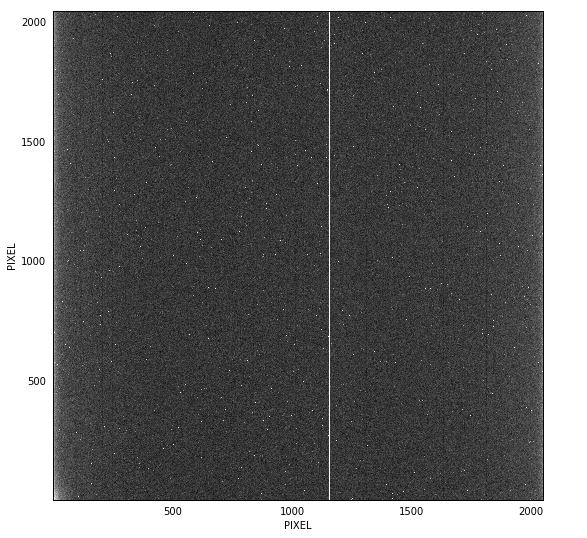

In [3]:
dark_flat_list = []

print("[reduction] Changing to dark directory", dark_flat_dir, "...")
os.chdir(dark_flat_dir)

for frame in glob.glob("*.fit"):
    
    print("[reduction] Appending frame", frame, "to dark list ...")
    dark_flat_list.append(frame)
    
print("[reduction] Sorting dark list ...")
dark_flat_list.sort()

print("[reduction] Loading dark frame example", dark_flat_list[-1], " ")
hdu = fits.open(dark_flat_list[-1])

print("[reduction] Reading dark frame example data ...")
frame_data = hdu[0].data

print("[reduction] Converting dark frame example to FITSFigure object ...")
fig = aplpy.FITSFigure(frame_data)

print("[reduction] Displaying dark frame example ...")
fig.show_grayscale()

### Combine dark frames (for flat correction)
Note that the constant features (hot pixels, dead pixel arrays) remain, but the background becomes darker. We are seeing the effects of the "averaging out" of randomness, but non-random noise remains as a systematic defect (which is what we're going to remove via subtraction).

[reduction] Median-combining dark frames ...
[reduction] Converting master dark to HDU object ...
[reduction] Reading master dark data ...
[reduction] Converting master dark to FITSFigure object ...


[reduction] Displaying master dark ...
INFO: Auto-setting vmin to  1.236e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.458e+03 [aplpy.core]


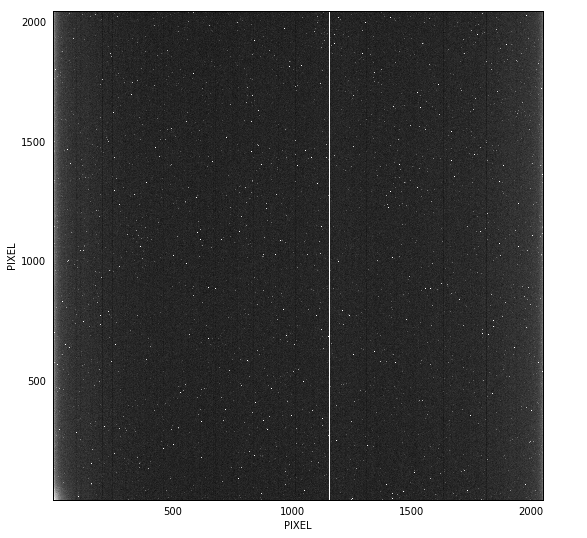

In [4]:
print("[reduction] Median-combining dark frames ...")
master_dark_for_flat = ccdproc.combine(dark_flat_list, method="median", unit="adu")

print("[reduction] Converting master dark to HDU object ...")
hdu = master_dark_for_flat.to_hdu()

print("[reduction] Reading master dark data ...")
frame_data = hdu[0].data

print("[reduction] Converting master dark to FITSFigure object ...")
fig = aplpy.FITSFigure(frame_data)

print("[reduction] Displaying master dark ...")
fig.show_grayscale()

### Read dark frames (for object correction)
You should see that these darks look different. They have different hot pixels and dead arrays than the previous set of darks. The integration time for these darks is 30 seconds (which makes sense visually -- these dark frames are "lighter" than the frames with a longer integration time).

[reduction] Changing to dark directory /home/rcamuccio/Documents/pipeline-tutorials/data/reduction/dark/object ...
[reduction] Appending frame dark-20171119-003.fit to dark list ...
[reduction] Appending frame dark-20171119-004.fit to dark list ...
[reduction] Appending frame dark-20171119-001.fit to dark list ...
[reduction] Appending frame dark-20171119-002.fit to dark list ...
[reduction] Appending frame dark-20171119-005.fit to dark list ...
[reduction] Sorting dark list ...
[reduction] Loading dark frame example dark-20171119-005.fit  
[reduction] Reading dark frame example data ...
[reduction] Converting dark frame example to FITSFigure object ...


[reduction] Displaying dark frame example ...
INFO: Auto-setting vmin to  1.220e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.398e+03 [aplpy.core]


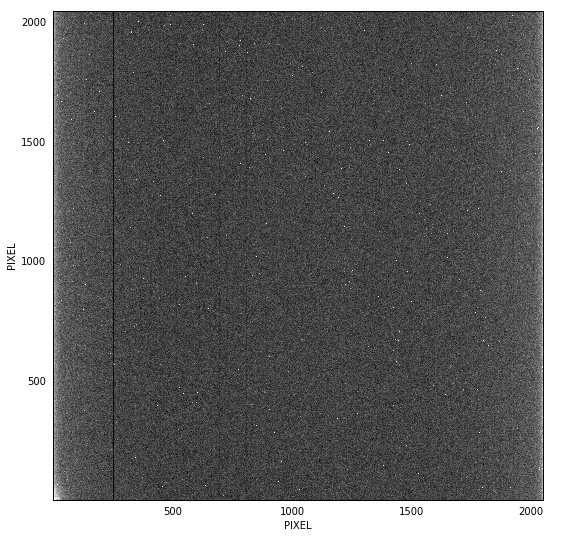

In [5]:
dark_object_list = []

print("[reduction] Changing to dark directory", dark_object_dir, "...")
os.chdir(dark_object_dir)

for frame in glob.glob("*.fit"):
    
    print("[reduction] Appending frame", frame, "to dark list ...")
    dark_object_list.append(frame)
    
print("[reduction] Sorting dark list ...")
dark_object_list.sort()

print("[reduction] Loading dark frame example", dark_object_list[-1], " ")
hdu = fits.open(dark_object_list[-1])

print("[reduction] Reading dark frame example data ...")
frame_data = hdu[0].data

print("[reduction] Converting dark frame example to FITSFigure object ...")
fig = aplpy.FITSFigure(frame_data)

print("[reduction] Displaying dark frame example ...")
fig.show_grayscale()

### Combine dark frames (for object correction)

[reduction] Median-combining dark frames ...
[reduction] Converting master dark to HDU object ...
[reduction] Reading master dark data ...
[reduction] Converting master dark to FITSFigure object ...


[reduction] Displaying master dark ...
INFO: Auto-setting vmin to  1.235e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.396e+03 [aplpy.core]


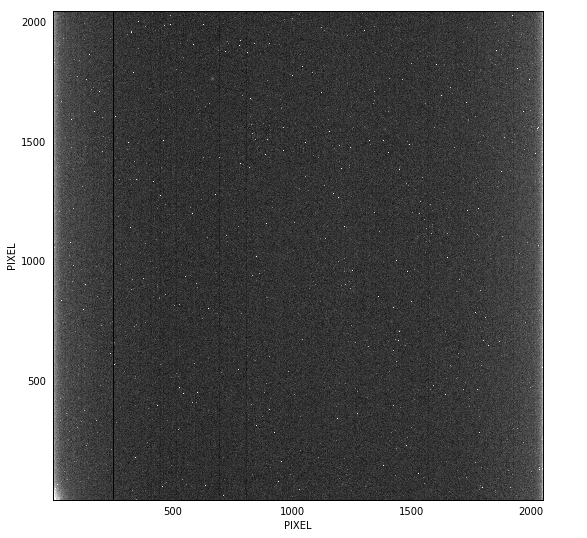

In [6]:
print("[reduction] Median-combining dark frames ...")
master_dark_for_object = ccdproc.combine(dark_object_list, method="median", unit="adu")

print("[reduction] Converting master dark to HDU object ...")
hdu = master_dark_for_object.to_hdu()

print("[reduction] Reading master dark data ...")
frame_data = hdu[0].data

print("[reduction] Converting master dark to FITSFigure object ...")
fig = aplpy.FITSFigure(frame_data)

print("[reduction] Displaying master dark ...")
fig.show_grayscale()

### Read flat frames
Flat frames represent the state of your blank canvas. It reveals all the systematic defects in your optical path, from the aperture of the telescope to the CCD sensor and everything in between. In the following flat, you'll see "donuts" (caused by dust), dead pixels, non-linear deviation along the fringes (caused by voltage bias, chip defects, or vignetting), and hot pixels. Division of the object frame by this canvas will (in principle) undo all of these deviations. The integration time for these flats is 12 seconds -- CCDPROC will account for the difference in integration time between the flats and their corresponding darks and scale them (although ideally the darks should have been 12 seconds rather than 60 seconds).

[reduction] Changing to flat directory /home/rcamuccio/Documents/pipeline-tutorials/data/reduction/flat ...
[reduction] Appending frame flat-20171119-002.fit to flat list ...
[reduction] Appending frame flat-20171119-009.fit to flat list ...
[reduction] Appending frame flat-20171119-005.fit to flat list ...
[reduction] Appending frame flat-20171119-006.fit to flat list ...
[reduction] Appending frame flat-20171119-004.fit to flat list ...
[reduction] Appending frame flat-20171119-001.fit to flat list ...
[reduction] Appending frame flat-20171119-010.fit to flat list ...
[reduction] Appending frame flat-20171119-008.fit to flat list ...
[reduction] Appending frame flat-20171119-007.fit to flat list ...
[reduction] Appending frame flat-20171119-003.fit to flat list ...
[reduction] Sorting flat list ...
[reduction] Loading flat frame example flat-20171119-010.fit  
[reduction] Reading flat frame example data ...
[reduction] Converting flat frame example to FITSFigure object ...


[reduction] Displaying flat frame example ...
INFO: Auto-setting vmin to  2.637e+04 [aplpy.core]
INFO: Auto-setting vmax to  3.008e+04 [aplpy.core]


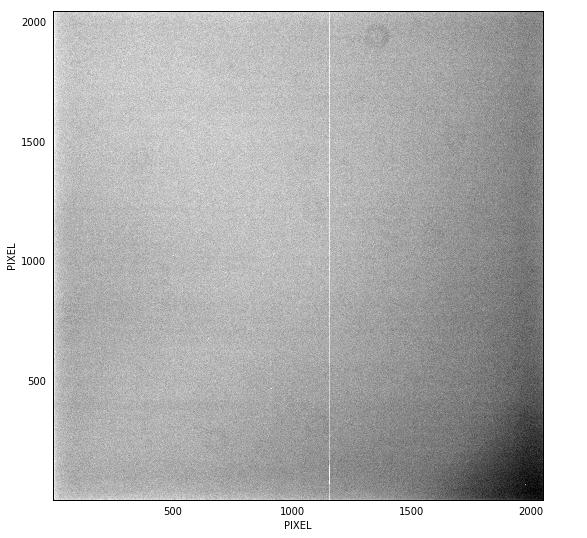

In [7]:
flat_list = []

print("[reduction] Changing to flat directory", flat_dir, "...")
os.chdir(flat_dir)

for frame in glob.glob("*.fit"):
    
    print("[reduction] Appending frame", frame, "to flat list ...")
    flat_list.append(frame)
    
print("[reduction] Sorting flat list ...")
flat_list.sort()

print("[reduction] Loading flat frame example", flat_list[-1], " ")
hdu = fits.open(flat_list[-1])

print("[reduction] Reading flat frame example data ...")
frame_data = hdu[0].data

print("[reduction] Converting flat frame example to FITSFigure object ...")
fig = aplpy.FITSFigure(frame_data)

print("[reduction] Displaying flat frame example ...")
fig.show_grayscale()

### Create median-combined flat frame
After median-combining the individual flats, one can see the features more clearly, including the hot pixels.

[reduction] Median-combining flat frames ...
[reduction] Reading median-combined frame data ...
[reduction] Converting data to FITSFigure ...


[reduction] Displaying median-combined flat ...
INFO: Auto-setting vmin to  2.629e+04 [aplpy.core]
INFO: Auto-setting vmax to  2.992e+04 [aplpy.core]


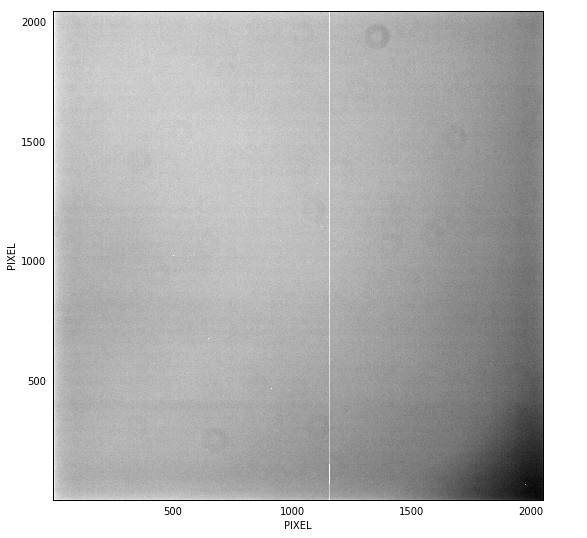

In [9]:
print("[reduction] Median-combining flat frames ...")
combined_flat = ccdproc.combine(flat_list, method="median", unit="adu")

print("[reduction] Reading median-combined frame data ...")
combined_flat_data = np.asarray(combined_flat)

print("[reduction] Converting data to FITSFigure ...")
fig = aplpy.FITSFigure(combined_flat_data)

print("[reduction] Displaying median-combined flat ...")
fig.show_grayscale()

### Create dark-subtracted flat frame
The hot pixels that were previously visible are now removed.

[reduction] Subtracting dark from median-combined flat ...
[reduction] Reading dark-subtracted data ...
[reduction] Converting dark-subtracted data to FITSFigure object ...


[reduction] Displaying dark-subtracted flat ...
INFO: Auto-setting vmin to  2.603e+04 [aplpy.core]
INFO: Auto-setting vmax to  2.964e+04 [aplpy.core]


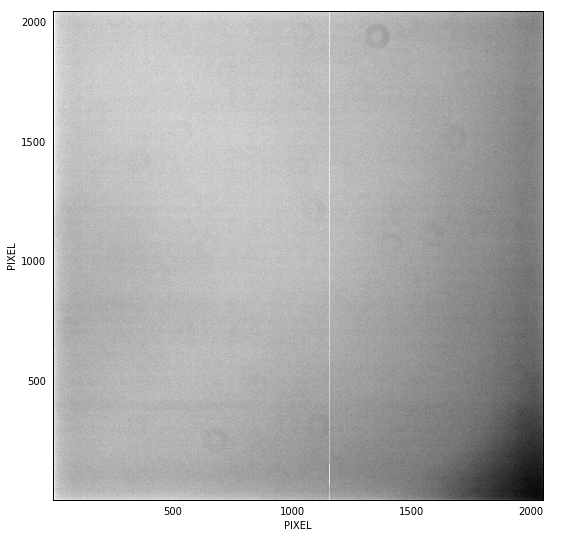

In [10]:
print("[reduction] Subtracting dark from median-combined flat ...")
master_flat = ccdproc.subtract_dark(combined_flat, master_dark_for_flat, data_exposure=combined_flat.header["exposure"]*u.second, dark_exposure=master_dark_for_flat.header["exposure"]*u.second, scale=True)

print("[reduction] Reading dark-subtracted data ...")
master_flat_data = np.asarray(master_flat)

print("[reduction] Converting dark-subtracted data to FITSFigure object ...")
fig = aplpy.FITSFigure(master_flat_data)

print("[reduction] Displaying dark-subtracted flat ...")
fig.show_grayscale()

### Create normalized flatfield
One must normalize the master flat by dividing the master by its average pixel value. Dividing the object frames by this normalized flatfield frame will produce a visibly-identical image, but normalized to unity so that division will not affect the photon count statistics in the object frame.

[reduction] Converting master flat to array ...
[reduction] Normalizing master flat array by mean ...
[reduction] Master flat mean: 28415.852019476904
[reduction] Converting normalized flatfield to CCDData object ...
[reduction] Converting normalized flatfield to FITSFigure ...


[reduction] Displaying normalized flatfield ...
INFO: Auto-setting vmin to  9.161e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.043e+00 [aplpy.core]


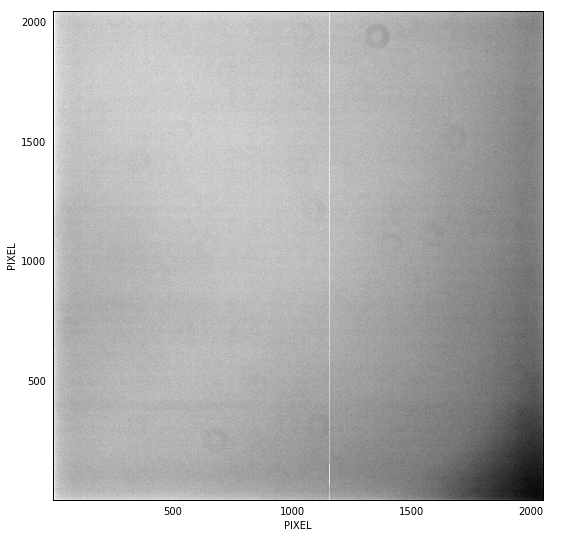

In [11]:
print("[reduction] Converting master flat to array ...")
master_flat_data = np.asarray(master_flat)

print("[reduction] Normalizing master flat array by mean ...")
array_mean = np.mean(master_flat_data)
print("[reduction] Master flat mean:", array_mean)
flatfield_data = master_flat_data / array_mean

print("[reduction] Converting normalized flatfield to CCDData object ...")
flatfield = ccdproc.CCDData(flatfield_data, unit="adu")

print("[reduction] Converting normalized flatfield to FITSFigure ...")
fig = aplpy.FITSFigure(flatfield_data)

print("[reduction] Displaying normalized flatfield ...")
fig.show_grayscale()

### Read object frames
Finally, we can see an example of raw data of NGC1341 in unfiltered optical light. In the frame are several astronomical sources, including the target in the center of the frame and other stars. Along with these sources are image artifacts: dead pixels, hot pixels, and all of those other deviations we saw earlier. Let's remove them, since their presence affects our scientific results.

[reduction] Changing to object directory /home/rcamuccio/Documents/pipeline-tutorials/data/reduction/ngc1341 ...
[reduction] Appending frame ngc1341-20171119-005.fit to object list...
[reduction] Appending frame ngc1341-20171119-009.fit to object list...
[reduction] Appending frame ngc1341-20171119-006.fit to object list...
[reduction] Appending frame ngc1341-20171119-007.fit to object list...
[reduction] Appending frame ngc1341-20171119-010.fit to object list...
[reduction] Appending frame ngc1341-20171119-002.fit to object list...
[reduction] Appending frame ngc1341-20171119-003.fit to object list...
[reduction] Appending frame ngc1341-20171119-008.fit to object list...
[reduction] Appending frame ngc1341-20171119-001.fit to object list...
[reduction] Appending frame ngc1341-20171119-004.fit to object list...
[reduction] Opening frame ngc1341-20171119-010.fit ...
[reduction] Reading raw frame data ...
[reduction] Converting raw frame data to FITSFigure object ...


[reduction] Showing FITSFigure object ...
INFO: Auto-setting vmin to  1.372e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.635e+03 [aplpy.core]


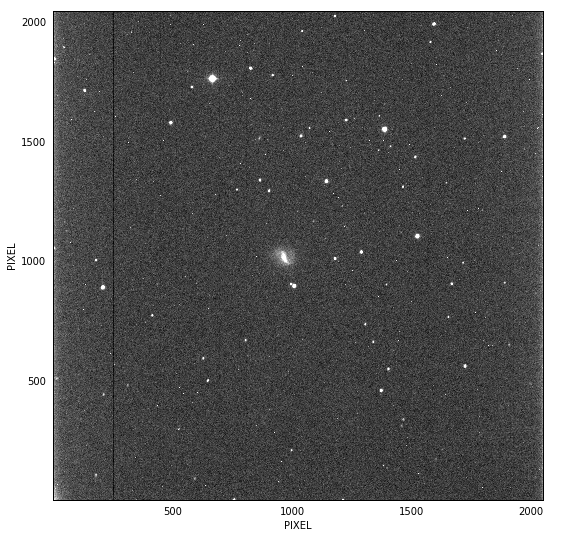

In [12]:
object_list = []

print("[reduction] Changing to object directory", object_dir, "...")
os.chdir(object_dir)

for frame in glob.glob("*.fit"):
    
    print("[reduction] Appending frame", frame, "to object list...")
    object_list.append(frame)
        
object_list.sort()

print("[reduction] Opening frame", object_list[-1], "...")
hdu = fits.open(object_list[-1])

print("[reduction] Reading raw frame data ...")
raw_frame_data = hdu[0].data

print("[reduction] Converting raw frame data to FITSFigure object ...")
fig = aplpy.FITSFigure(raw_frame_data)

print("[reduction] Showing FITSFigure object ...")
fig.show_grayscale()

### Reduce object frames to calibrated frames

The background should look much smoother. The dead pixels have been corrected, and the hot pixels have been removed.

[reduction] Reading object frame ngc1341-20171119-001.fit ...
[reduction] Dark correcting object ngc1341-20171119-001.fit ...
[reduction] Flatfield correcting object ngc1341-20171119-001.fit ...
[reduction] Saving calibrated object ngc1341-20171119-001.fit ...
[reduction] Reading object frame ngc1341-20171119-002.fit ...
[reduction] Dark correcting object ngc1341-20171119-002.fit ...
[reduction] Flatfield correcting object ngc1341-20171119-002.fit ...
[reduction] Saving calibrated object ngc1341-20171119-002.fit ...
[reduction] Reading object frame ngc1341-20171119-003.fit ...
[reduction] Dark correcting object ngc1341-20171119-003.fit ...
[reduction] Flatfield correcting object ngc1341-20171119-003.fit ...
[reduction] Saving calibrated object ngc1341-20171119-003.fit ...
[reduction] Reading object frame ngc1341-20171119-004.fit ...
[reduction] Dark correcting object ngc1341-20171119-004.fit ...
[reduction] Flatfield correcting object ngc1341-20171119-004.fit ...
[reduction] Saving cal

[reduction] Displaying example frame ...
INFO: Auto-setting vmin to  1.058e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.029e+02 [aplpy.core]


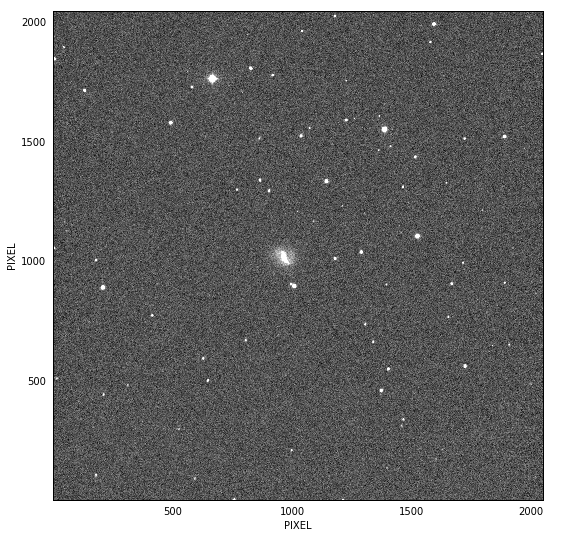

In [13]:
for frame in object_list:
    
    print("[reduction] Reading object frame", frame, "...")
    object_frame = ccdproc.fits_ccddata_reader(frame, unit="adu")
    
    print("[reduction] Dark correcting object", frame, "...")
    object_min_dark = ccdproc.subtract_dark(object_frame, master_dark_for_object, data_exposure=object_frame.header["exposure"]*u.second, dark_exposure=master_dark_for_object.header["exposure"]*u.second, scale=True)

    print("[reduction] Flatfield correcting object", frame, "...")
    cal_object_frame = ccdproc.flat_correct(object_min_dark, master_flat)
    
    if save_cal == "yes":

        print("[reduction] Saving calibrated object", frame, "...")
        ccdproc.fits_ccddata_writer(cal_object_frame, str(output_dir) + "/cal-" + str(frame), overwrite=True)
    
print("[reduction] Converting example calibrated object", object_list[-1], "to HDU object ...")
hdu = cal_object_frame.to_hdu()

print("[reduction] Reading example frame data ...")
cal_object_frame_data = hdu[0].data

print("[reduction] Converting example frame to FITSFigure ...")
fig = aplpy.FITSFigure(cal_object_frame_data)

print("[reduction] Displaying example frame ...")
fig.show_grayscale()

### Detect and remove cosmic rays
Finally, we remove cosmic ray signals and other bogus transients. From the output in this tutorial, it might be difficult to see the effects, but upon closer inspection using a FITS file viewer (like SAOImage DS9), one can easily see the difference.

[reduction] Detecting events ...
[reduction] Detected 5964 events ...
[reduction] Creating FITSFigure of cleaned array ...


[reduction] Displaying cleaned array ...
INFO: Auto-setting vmin to  1.066e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.931e+02 [aplpy.core]
[reduction] Creating HDU object with cleaned array ...
[reduction] Saving cleaned array ...


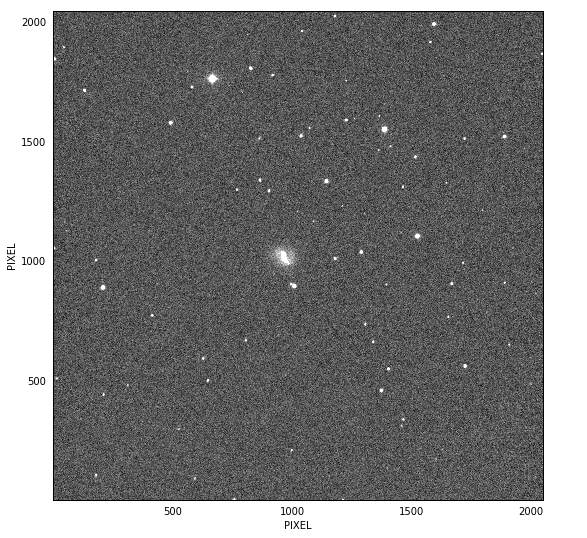

In [14]:
print("[reduction] Detecting events ...")
crmask, cleanarr = astroscrappy.detect_cosmics(cal_object_frame_data, inmask=None, sigclip=4.0, satlevel=np.inf, sepmed=False, cleantype="medmask", fsmode="median")

events = 0

for row in crmask:
    
    for cr in row:
        
        if cr == True:
            
            events += 1
        
print("[reduction] Detected", events, "events ...")

print("[reduction] Creating FITSFigure of cleaned array ...")
fig = aplpy.FITSFigure(cleanarr)

print("[reduction] Displaying cleaned array ...")
fig.show_grayscale()

print("[reduction] Creating HDU object with cleaned array ...")
hdu = fits.PrimaryHDU(cleanarr)

print("[reduction] Saving cleaned array ...")
hdu.writeto(output_dir + "/clean.fit", overwrite=True)

# ...
### EXPERIMENTAL SECTION

INFO: Auto-setting vmin to  1.058e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.029e+02 [aplpy.core]


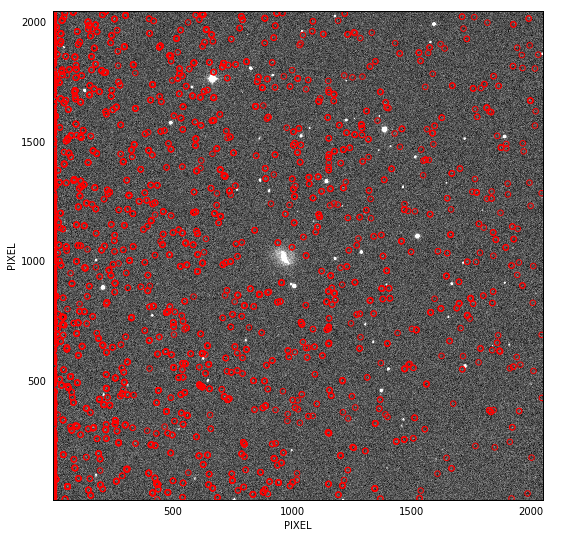

In [14]:
x_pos, y_pos = [], []
row_num = 0

for row in crmask:
    
    row_list = row.tolist()
    
    for item in row_list:
        
        if item == True:
            x_pos.append(row_list.index(item))
            y_pos.append(row_num)
            
        else:
            pass
        
    row_num += 1
    
fig = aplpy.FITSFigure(cal_object_frame_data)
fig.show_grayscale()  
fig.show_markers(x_pos, y_pos)
#fig.save("marker.png")

In [15]:
print(np.shape(crmask))

(2048, 2048)


In [16]:
print(crmask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
